In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing import List, TypedDict, Annotated
from dotenv import load_dotenv

In [2]:
load_dotenv()

llm = ChatOpenAI(model="gpt-4.1-nano")

In [3]:
# build state graph
class JokeState(TypedDict):
    topic: str
    joke: str
    explaination: str

In [4]:
def generate_joke(state: JokeState):
    prompt = f"Tell me a joke about {state['topic']}"

    # call llm to get response
    response = llm.invoke([HumanMessage(content=prompt)])

    # add response to state
    return {'joke': response.content}

In [5]:
def explain_joke(state: JokeState):
    prompt = f"Explain the joke: {state['joke']}"

    # call llm to get response
    response = llm.invoke([HumanMessage(content=prompt)])

    # add response to state
    return {'explaination': response.content}

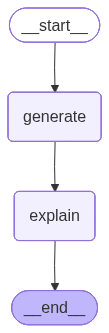

In [6]:
# state graph
graph = StateGraph(JokeState)

# add nodes
graph.add_node("generate", generate_joke)
graph.add_node("explain", explain_joke)

# add edges
graph.add_edge(START, "generate")
graph.add_edge("generate", "explain")
graph.add_edge("explain", END)

# checkpointer - save each state to memory
checkpointer = InMemorySaver()

# graph compilation
workflow = graph.compile(checkpointer=checkpointer)
workflow

In [7]:
thread_id = "1"
config = {"configurable": {"thread_id": thread_id}}

initial_state = {
    "topic": "cars"
}

final_state = workflow.invoke(initial_state, config=config)
print(final_state) # final_state

{'topic': 'cars', 'joke': 'Why did the car get a promotion?\n\nBecause it was always outstanding in its field!', 'explaination': 'This joke is a play on words involving the phrase "outstanding in its field." \n\n**Here\'s the explanation:**\n- The phrase "outstanding in its field" is a common idiom meaning someone is exceptional at their profession or area of expertise.\n- In the joke, it\'s used literally: a car is "outstanding in its field"—meaning it’s physically standing out in a field, like a cow might be in a rural setting.\n- The humor arises from this double meaning: the phrase simultaneously suggests the car is excellent at its job (hence deserving a promotion) and that it\'s literally outdoors in a field.\n\nSo, the joke makes a pun by combining the idiomatic expression with a literal image, creating a humorous twist.'}


In [8]:
list(workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'cars', 'joke': 'Why did the car get a promotion?\n\nBecause it was always outstanding in its field!', 'explaination': 'This joke is a play on words involving the phrase "outstanding in its field." \n\n**Here\'s the explanation:**\n- The phrase "outstanding in its field" is a common idiom meaning someone is exceptional at their profession or area of expertise.\n- In the joke, it\'s used literally: a car is "outstanding in its field"—meaning it’s physically standing out in a field, like a cow might be in a rural setting.\n- The humor arises from this double meaning: the phrase simultaneously suggests the car is excellent at its job (hence deserving a promotion) and that it\'s literally outdoors in a field.\n\nSo, the joke makes a pun by combining the idiomatic expression with a literal image, creating a humorous twist.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3360-dc82-6f64-8002-066d1a9ec8cc'}}, met

In [9]:
thread_id = "2"
config = {"configurable": {"thread_id": thread_id}}

initial_state = {
    "topic": "pizza"
}

final_state = workflow.invoke(initial_state, config=config)
print(final_state) # final_state

{'topic': 'pizza', 'joke': 'Why did the pizza hide? Because it was feeling a little crust-fallen!', 'explaination': 'Sure! The joke is a play on words involving pizza and the phrase "crust-fallen." It combines "crust," which is the outer edge of a pizza, with the phrase "heartfallen," meaning sad or disappointed. \n\nSo, when it says the pizza was "feeling a little crust-fallen," it\'s a pun suggesting that the pizza is sad or disappointed—like "heartfallen"—but using "crust" to make it funny because crust relates to pizza. The idea of a pizza hiding because it\'s feeling sad creates a humorous mental image, enhanced by the clever pun.'}


In [10]:
list(workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza hide? Because it was feeling a little crust-fallen!', 'explaination': 'Sure! The joke is a play on words involving pizza and the phrase "crust-fallen." It combines "crust," which is the outer edge of a pizza, with the phrase "heartfallen," meaning sad or disappointed. \n\nSo, when it says the pizza was "feeling a little crust-fallen," it\'s a pun suggesting that the pizza is sad or disappointed—like "heartfallen"—but using "crust" to make it funny because crust relates to pizza. The idea of a pizza hiding because it\'s feeling sad creates a humorous mental image, enhanced by the clever pun.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3361-1977-6064-8002-20ed6b5bb332'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-16T21:49:03.927292+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3361

### Time Travel

- Every state snapshot has a checkpoint_id, that specifies that stage of execution
- using the checkpoint_id we can execute the workfrom, starting from that point

In [12]:
# Here I have used a checkpoint after the first checkpoint execution is completed in the "Pizza" thread, 
# so I am passing the checkpoint_id to the config of the second thread
config1 = {"configurable": {"thread_id": thread_id, 'checkpoint_id': '1f0c3361-0467-6d5e-8000-d97931c69bfb'}}

# invoking the workflow from that checkpoint, initial_state is not required (None)
debug_final_state = workflow.invoke(None, config=config1)
print(debug_final_state) # final_state

{'topic': 'pizza', 'joke': 'Why did the pizza go to the party? Because it knew how to have a slice of the fun!', 'explaination': 'Sure! The joke plays on a pun involving the word "slice" and the idea of having fun. \n\nIn the joke, the "pizza" is personified and portrayed as going to a party. The punchline, "Because it knew how to have a slice of the fun," is a play on words:\n\n- "Slice" refers to a piece of pizza (a slice).\n- "Have a slice of the fun" sounds similar to "have a slice of the fun," which can be humorously understood as "participate in the fun."\n\nSo, it\'s funny because it combines the literal part of pizza (a slice) with the idiomatic expression of enjoying or sharing in the fun at a party. The joke is a lighthearted pun that makes a pizza seem like a fun, social being who knows how to enjoy a good time!'}


In [13]:
list(workflow.get_state_history({'configurable': {'thread_id': '2'}}))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the party? Because it knew how to have a slice of the fun!', 'explaination': 'Sure! The joke plays on a pun involving the word "slice" and the idea of having fun. \n\nIn the joke, the "pizza" is personified and portrayed as going to a party. The punchline, "Because it knew how to have a slice of the fun," is a play on words:\n\n- "Slice" refers to a piece of pizza (a slice).\n- "Have a slice of the fun" sounds similar to "have a slice of the fun," which can be humorously understood as "participate in the fun."\n\nSo, it\'s funny because it combines the literal part of pizza (a slice) with the idiomatic expression of enjoying or sharing in the fun at a party. The joke is a lighthearted pun that makes a pizza seem like a fun, social being who knows how to enjoy a good time!'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3362-ad85-623c-8002-2b60a335aee0'}}, metadata

If we see here in the above we can easily identify that when we re-started with checkpoint of second stage, we then went on to execute the 3rd and 4th stages again. It can be confirmed by seeing the joke and explaination (both are different)

### Updating State and executing it

In [ ]:
# here I am passing the checkpoint_id to the config of the second stage
config2 = {
    "configurable": {
        "thread_id": "2",
        'checkpoint_id': '1f0c308d-f7c1-66e8-8000-0c921c9d736f',  # Checkpoint after generate in thread 2 - second checkpoint
        'checkpoint_ns': ''
    }
}

# invoking the workflow from that checkpoint, with updated state - here it will continue from the "explain" as next node
new_config = workflow.update_state(config2, {'topic': 'pasta'})
new_config

In [15]:
list(workflow.get_state_history({'configurable': {'thread_id': '2'}}))

[StateSnapshot(values={'topic': 'pasta'}, next=('explain',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3363-dcfb-6466-8000-cba3194a7931'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-11-16T21:50:18.115794+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c308d-f7c1-66e8-8000-0c921c9d736f'}}, tasks=(PregelTask(id='8dcd1df5-66b1-3b61-c1de-72eb93f0d173', name='explain', path=('__pregel_pull', 'explain'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the party? Because it knew how to have a slice of the fun!', 'explaination': 'Sure! The joke plays on a pun involving the word "slice" and the idea of having fun. \n\nIn the joke, the "pizza" is personified and portrayed as going to a party. The punchline, "Because it knew how to have a slice of the fun," is a play on words

In [16]:
history = list(workflow.get_state_history(config={"configurable": {"thread_id": "2"}}))
for i, snapshot in enumerate(history):
    print(f"{i}. Step {snapshot.metadata['step']}: checkpoint_id = {snapshot.config['configurable']['checkpoint_id']}")
    print(f"   next nodes: {snapshot.next}")
    print()

0. Step 0: checkpoint_id = 1f0c3363-dcfb-6466-8000-cba3194a7931
   next nodes: ('explain',)

1. Step 2: checkpoint_id = 1f0c3362-ad85-623c-8002-2b60a335aee0
   next nodes: ()

2. Step 1: checkpoint_id = 1f0c3362-9de8-69e6-8001-c953986eb3fd
   next nodes: ('explain',)

3. Step 2: checkpoint_id = 1f0c3361-1977-6064-8002-20ed6b5bb332
   next nodes: ()

4. Step 1: checkpoint_id = 1f0c3361-0ba1-6782-8001-b74a84f66fed
   next nodes: ('explain',)

5. Step 0: checkpoint_id = 1f0c3361-0467-6d5e-8000-d97931c69bfb
   next nodes: ('generate',)

6. Step -1: checkpoint_id = 1f0c3361-0466-6c92-bfff-ae23e2d52be4
   next nodes: ('__start__',)



In [20]:
# To start with generation we need to use the step -1's checkpoint_id to start the workflow
config3 = {
    "configurable": {
        "thread_id": "2",
        'checkpoint_id': '1f0c3361-0466-6c92-bfff-ae23e2d52be4',  # Checkpoint after generate in thread 2 - second checkpoint
        'checkpoint_ns': ''
    }
}

# invoking the workflow from that checkpoint, with updated state - here it will continue from the "explain" as next node
new_config_1 = workflow.update_state(config3, {'topic': 'pasta'})
new_config_1

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c337f-e6bb-6b74-8000-6664c119e43d'}}

In [21]:
list(workflow.get_state_history({'configurable': {'thread_id': '2'}}))

[StateSnapshot(values={'topic': 'pasta'}, next=('generate',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c337f-e6bb-6b74-8000-6664c119e43d'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-11-16T22:02:50.757592+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3361-0466-6c92-bfff-ae23e2d52be4'}}, tasks=(PregelTask(id='74f74e13-1163-b6aa-c469-8db008ddbc13', name='generate', path=('__pregel_pull', 'generate'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pasta'}, next=('explain',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3363-dcfb-6466-8000-cba3194a7931'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-11-16T21:50:18.115794+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0c308d-f7c1-66e8-

In [22]:
history = list(workflow.get_state_history(config={"configurable": {"thread_id": "2"}}))
for i, snapshot in enumerate(history):
    print(f"{i}. Step {snapshot.metadata['step']}: checkpoint_id = {snapshot.config['configurable']['checkpoint_id']}")
    print(f"   next nodes: {snapshot.next}")
    print()

0. Step 0: checkpoint_id = 1f0c337f-e6bb-6b74-8000-6664c119e43d
   next nodes: ('generate',)

1. Step 0: checkpoint_id = 1f0c3363-dcfb-6466-8000-cba3194a7931
   next nodes: ('explain',)

2. Step 2: checkpoint_id = 1f0c3362-ad85-623c-8002-2b60a335aee0
   next nodes: ()

3. Step 1: checkpoint_id = 1f0c3362-9de8-69e6-8001-c953986eb3fd
   next nodes: ('explain',)

4. Step 2: checkpoint_id = 1f0c3361-1977-6064-8002-20ed6b5bb332
   next nodes: ()

5. Step 1: checkpoint_id = 1f0c3361-0ba1-6782-8001-b74a84f66fed
   next nodes: ('explain',)

6. Step 0: checkpoint_id = 1f0c3361-0467-6d5e-8000-d97931c69bfb
   next nodes: ('generate',)

7. Step -1: checkpoint_id = 1f0c3361-0466-6c92-bfff-ae23e2d52be4
   next nodes: ('__start__',)



In [23]:
new_config_1

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c337f-e6bb-6b74-8000-6664c119e43d'}}

In [24]:
workflow.invoke(None, config=new_config_1)

{'topic': 'pasta',
 'joke': 'Why did the spaghetti go to the party? Because it was feeling saucy!',
 'explaination': 'The joke is a playful pun that combines a literal and a figurative meaning. The question asks why the spaghetti went to the party, and the punchline is "Because it was feeling saucy!"\n\nHere\'s the explanation:\n\n- "Saucy" is a slang term meaning confident, lively, or flirtatious, often used to describe someone with a bold or playful attitude.\n\n- In cooking, "sauce" is a liquid or semi-liquid served with food, such as pasta.\n\n- The joke plays on the word "saucy," linking it to "sauce." Since spaghetti is often served with sauce, the phrase humorously suggests that the spaghetti\'s "saucy" feeling is a pun, implying it\'s feeling lively or bold because of the sauce it\'s associated with.\n\nOverall, it\'s a pun that combines the culinary context with a fun joke about personality traits.'}

In [25]:
list(workflow.get_state_history({'configurable': {'thread_id': '2'}}))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to the party? Because it was feeling saucy!', 'explaination': 'The joke is a playful pun that combines a literal and a figurative meaning. The question asks why the spaghetti went to the party, and the punchline is "Because it was feeling saucy!"\n\nHere\'s the explanation:\n\n- "Saucy" is a slang term meaning confident, lively, or flirtatious, often used to describe someone with a bold or playful attitude.\n\n- In cooking, "sauce" is a liquid or semi-liquid served with food, such as pasta.\n\n- The joke plays on the word "saucy," linking it to "sauce." Since spaghetti is often served with sauce, the phrase humorously suggests that the spaghetti\'s "saucy" feeling is a pun, implying it\'s feeling lively or bold because of the sauce it\'s associated with.\n\nOverall, it\'s a pun that combines the culinary context with a fun joke about personality traits.'}, next=(), config={'configurable': {'thread_id': '2', 'che